# InterAnnual DO

In [1]:
# imports
from importlib import reload

import numpy as np
from scipy.interpolate import interp1d

import pandas

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import seaborn as sns

from siosandbox.cugn import clusters
from siosandbox.cugn import grid_utils
from siosandbox.cugn import io as cugn_io
from siosandbox import plot_utils

from gsw import conversions, density
import gsw

# Load

In [9]:
line = '90'

# Load
items = cugn_io.load_line(line)
grid_tbl = items['grid_tbl']
ds = items['ds']

# Fill
grid_utils.fill_in_grid(grid_tbl, ds)

In [10]:
grid_tbl.head()

,depth,profile,row,col,doxy,doxy_p,time,lon,z,CT,SA,sigma0,SO,N,chla,T
0,0,32173,17,16,252.912731,88.939052,2016-12-14 19:52:21,-117.460120,10,16.249462,33.523891,24.446819,1.033524,6.383201,0.169041,16.217727
1,0,32174,17,16,252.951126,89.164786,2016-12-14 20:47:19,-117.463420,10,16.214990,33.522302,24.453442,1.032982,5.148775,0.176322,16.183300
2,0,32175,17,17,253.346587,80.334728,2016-12-14 21:38:13,-117.465688,10,16.158025,33.511012,24.457791,1.033375,6.983573,0.252030,16.126182
3,0,32176,17,17,254.551252,86.192469,2016-12-14 22:50:08,-117.471270,10,16.057278,33.502061,24.473762,1.036203,5.451822,0.431141,16.025455
4,0,32177,17,16,251.471860,85.101580,2016-12-15 00:11:51,-117.477442,10,16.372075,33.522704,24.417984,1.030055,5.484878,0.267575,16.340000


## Episodes

In [11]:
perc = 98.
grid_outliers, _, ds = grid_utils.gen_outliers(line, perc)
clusters.generate_clusters(grid_outliers)

cstats = clusters.cluster_stats(grid_outliers)

Found 386 unique clusters


In [12]:
cstats.head()

,z,lon,doxy,time,SA,CT,sigma0,SO,chla,max_doxy,max_SO,max_chla,N,cluster
0,15.600000,-118.009290,278.942976,2017-03-17 05:13:22.506666752,33.417848,14.997837,24.640720,1.111353,0.376499,309.040496,1.237211,0.710987,75,0
1,12.500000,-117.987563,263.682135,2017-04-09 09:25:06.666666496,33.504671,16.216080,24.439004,1.076490,0.220169,271.135380,1.099654,0.319463,12,1
2,13.076923,-119.560430,268.295324,2017-04-15 22:35:44.923077120,33.545435,14.173875,24.914860,1.052789,1.522748,271.505720,1.060757,2.138465,13,2
3,19.375000,-119.904488,264.906934,2017-06-21 04:50:49.875000064,33.475110,15.639963,24.546332,1.069439,1.439475,267.124543,1.082783,2.477573,16,3
4,18.674699,-117.641209,295.869543,2017-07-07 12:29:09.132529664,33.563195,15.655587,24.601511,1.198933,0.920417,423.426695,1.806465,4.022911,83,4


# In-shore + Shallow

In [13]:
cut_in = grid_tbl.lon > -119.
cut_depth = grid_tbl.z < 40.
#
grid_ins = grid_tbl[cut_depth & cut_in]
len(grid_ins)

20073

In [14]:
grid_ins.head()

,depth,profile,row,col,doxy,doxy_p,time,lon,z,CT,SA,sigma0,SO,N,chla,T
0,0,32173,17,16,252.912731,88.939052,2016-12-14 19:52:21,-117.460120,10,16.249462,33.523891,24.446819,1.033524,6.383201,0.169041,16.217727
1,0,32174,17,16,252.951126,89.164786,2016-12-14 20:47:19,-117.463420,10,16.214990,33.522302,24.453442,1.032982,5.148775,0.176322,16.183300
2,0,32175,17,17,253.346587,80.334728,2016-12-14 21:38:13,-117.465688,10,16.158025,33.511012,24.457791,1.033375,6.983573,0.252030,16.126182
3,0,32176,17,17,254.551252,86.192469,2016-12-14 22:50:08,-117.471270,10,16.057278,33.502061,24.473762,1.036203,5.451822,0.431141,16.025455
4,0,32177,17,16,251.471860,85.101580,2016-12-15 00:11:51,-117.477442,10,16.372075,33.522704,24.417984,1.030055,5.484878,0.267575,16.340000


# Time series

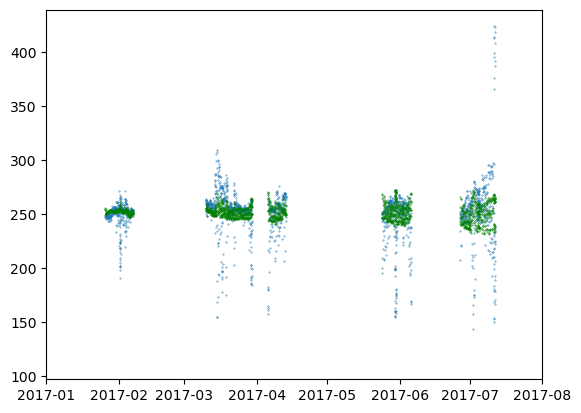

In [15]:
plt.clf()
ax = plt.gca()

ax.scatter(grid_ins.time, grid_ins.doxy, s=0.1)

# OC
ax.scatter(grid_ins.time, grid_ins.doxy/grid_ins.SO, s=0.1, color='g')

#ax.set_xlim(2017., 2019.)
ax.set_xlim(pandas.Timestamp('2017-01-01'), pandas.Timestamp('2017-08-01'))
plt.show()

## Resample

In [16]:
grid_resample = grid_ins[['time', 'doxy', 'SO', 'N', 'T', 'z', 'SA']]
grid_resample = grid_resample.set_index('time').resample('7D').mean().dropna().reset_index()
grid_resample_max = grid_ins[['time', 'doxy', 'SO', 'N', 'T', 'z', 'SA']]
grid_resample_max = grid_resample_max.set_index('time').resample('7D').apply(lambda x: max(x,key=abs,default=np.NaN)).dropna().reset_index()

In [17]:
grid_resample.head()

,time,doxy,SO,N,T,z,SA
0,2016-12-14,241.971500,0.979083,4.582660,15.694493,20.0,33.514862
1,2016-12-21,242.440260,0.960138,5.411151,14.583128,20.0,33.555173
2,2017-01-25,250.788548,0.993761,2.347366,14.658572,20.0,33.486924
3,2017-02-01,247.284594,0.980292,5.151956,14.686198,20.0,33.420055
4,2017-03-08,258.254440,1.022077,5.562913,14.576843,20.0,33.469051


In [18]:
grid_resample_max.head()

,time,doxy,SO,N,T,z,SA
0,2016-12-14,254.551252,1.036203,10.477194,16.845917,30.0,33.571935
1,2016-12-21,256.737353,1.020499,10.683402,15.434455,30.0,33.578573
2,2017-01-25,261.365342,1.036299,7.464123,15.102636,30.0,33.545356
3,2017-02-01,271.433326,1.072125,10.690585,15.735200,30.0,33.559239
4,2017-03-08,309.040496,1.237211,13.925959,15.636583,30.0,33.624340


In [19]:
grid_resample_max.SO.min()

0.9966654321912638

In [20]:
len(grid_resample), len(grid_resample_max)

(154, 154)

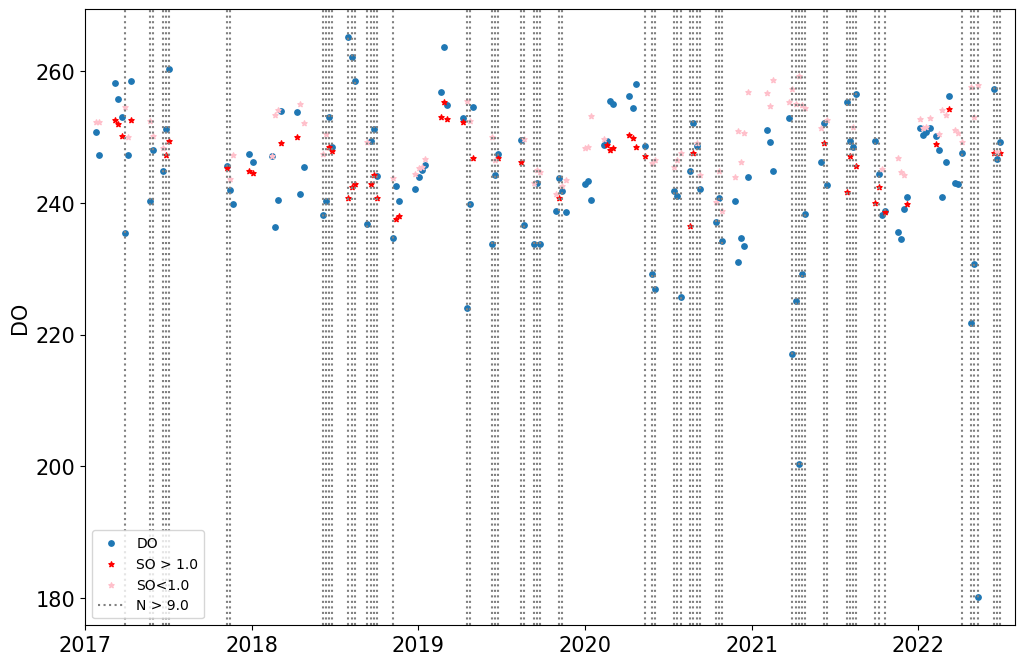

In [35]:
grid = grid_resample
sval = 15.0

fig = plt.figure(figsize=(12,8))
plt.clf()
ax = plt.gca()

ax.scatter(grid.time, grid.doxy, s=sval, label='DO')

# OC
# Split by gt/lt
sat_lim = 1.0
saturated = grid.SO > sat_lim
ax.scatter(grid.time[saturated], (grid.doxy/grid.SO)[saturated], s=sval, color='r', marker='*', label=f'SO > {sat_lim}')
ax.scatter(grid.time[~saturated], (grid.doxy/grid.SO)[~saturated], s=sval, color='pink', marker='*', label=f'SO<{sat_lim}')

# Episodes
'''
gd_clusters = (cstats.SO > 1.) & (cstats.lon > -119.) & (cstats.z < 50.)
cluster_IDs = cstats[gd_clusters].cluster.values
for cluster_ID in cluster_IDs:
    in_cluster = grid_outliers.cluster == cluster_ID
    # Take the mean time
    ctime = grid_outliers[in_cluster].time.mean()
    # 
    ax.axvline(ctime, color='r', ls='--')
'''

# N>XX
N_lim = 9.
idx_Nex = np.where(grid.N > N_lim)[0]
for idx in idx_Nex:
    ctime = grid.iloc[idx].time
    if idx == idx_Nex[0]:
        albl = f'N > {N_lim}'
    else:
        albl = None
    ax.axvline(ctime, color='gray', ls=':', label=albl)

#ax.set_xlim(2017., 2019.)
ax.set_xlim(pandas.Timestamp('2017-01-01'), pandas.Timestamp('2022-08-01'))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=1))

#
ax.set_ylabel('DO')
plot_utils.set_fontsize(ax, 15.)
ax.legend(loc='lower left')

#
plt.savefig('fig_interannual.png', dpi=300)

plt.show()

## Winter 2020

In [52]:
w2020 = (grid_resample.time > pandas.Timestamp('2020-02-01')) & (
    grid_resample.time < pandas.Timestamp('2020-05-01'))
#
grid_resample[w2020]

,time,doxy,SO,N,T,z,SA
67,2020-02-12,248.863672,0.996547,4.085104,15.138633,20.0,33.638227
68,2020-02-19,249.447959,1.002756,5.164965,15.340003,20.0,33.622870
69,2020-02-26,255.497919,1.029693,5.595081,15.449272,20.0,33.663921
70,2020-03-04,255.033165,1.027148,3.741156,15.434405,20.0,33.633420
71,2020-04-08,256.196694,1.023467,4.749464,15.012775,20.0,33.653732
72,2020-04-15,254.459866,1.018560,8.116430,14.980267,20.0,33.674313
73,2020-04-22,258.023481,1.038423,6.882458,15.376231,20.0,33.677503


## Summer 2017

In [45]:
s2017 = (grid_resample.time > pandas.Timestamp('2017-05-01')) & (
    grid_resample.time < pandas.Timestamp('2017-09-01'))
#
grid_resample[s2017]

,time,doxy,SO,N,T,z,SA
10,2017-05-24,240.322405,0.951731,9.809560,14.410001,20.0000,33.632378
11,2017-05-31,248.011983,0.991274,9.450391,14.970403,20.0000,33.637658
12,2017-06-21,244.826003,0.985816,10.193658,15.378991,20.0000,33.620605
13,2017-06-28,251.183337,1.015559,10.828744,15.586107,20.0000,33.557114
14,2017-07-05,260.390238,1.043751,12.859383,14.955173,21.4375,33.560628


## Explore Summer 2018

In [44]:
s2018 = (grid_resample.time > pandas.Timestamp('2018-05-01')) & (
    grid_resample.time < pandas.Timestamp('2018-09-01'))
#
grid_resample[s2018]

,time,doxy,SO,N,T,z,SA
27,2018-06-06,238.218345,0.962596,10.248119,15.366556,20.000000,33.797932
28,2018-06-13,240.379490,0.959342,12.850296,14.479609,20.000000,33.770520
29,2018-06-20,253.029920,1.018316,13.058065,15.131495,20.973451,33.761712
30,2018-06-27,248.461070,1.002483,12.688027,15.045781,20.116279,33.775810
31,2018-08-01,265.194734,1.101328,11.745944,17.004724,24.545455,33.715371
32,2018-08-08,262.129637,1.081167,12.060396,16.613936,23.943662,33.725739
33,2018-08-15,258.549017,1.064387,10.493393,16.565817,22.631579,33.699059


## Spring 2021

In [43]:
sp2021 = (grid_resample.time > pandas.Timestamp('2021-03-01')) & (
    grid_resample.time < pandas.Timestamp('2021-05-01'))
#
grid_resample[sp2021]

,time,doxy,SO,N,T,z,SA
95,2021-03-24,252.861500,0.990460,5.104572,13.978396,20.0,33.736065
96,2021-03-31,217.018900,0.843218,9.738898,13.295688,20.0,33.760159
97,2021-04-07,225.064320,0.882555,10.392769,13.840391,20.0,33.726371
98,2021-04-14,200.278704,0.772177,10.370310,12.830250,20.0,33.788678
99,2021-04-21,229.271732,0.899338,10.306009,13.851107,20.0,33.720069
100,2021-04-28,238.334196,0.936764,9.026291,14.064103,20.0,33.799112


----

# N and T

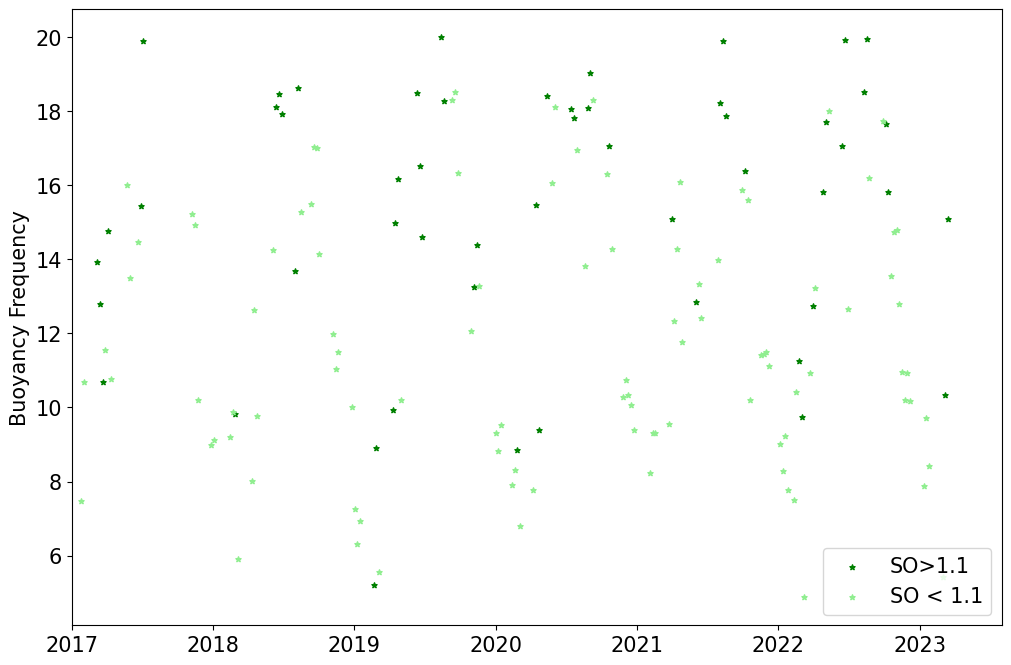

In [42]:
grid = grid_resample_max
sval = 15.0

fig = plt.figure(figsize=(12,8))
plt.clf()
ax = plt.gca()

#ax.scatter(grid.time, grid.doxy, s=sval)

# OC
# Split by gt/lt
sat_lim = 1.1
#saturated = grid_resample_max.SO > sat_lim
saturated = grid.SO > sat_lim
ax.scatter(grid.time[saturated], grid.N[saturated], s=sval, color='green', marker='*', label=f'SO>{sat_lim}')
ax.scatter(grid.time[~saturated], grid.N[~saturated], s=sval, color='lightgreen', marker='*', label=f'SO < {sat_lim}')

ax.set_xlim(pandas.Timestamp('2017-01-01'), pandas.Timestamp('2023-08-01'))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=1))

ax.set_ylabel('Buoyancy Frequency')
plot_utils.set_fontsize(ax, 15.)
ax.legend(fontsize=15., loc='lower right')

plt.savefig('fig_interannualN.png', dpi=300)

plt.show()

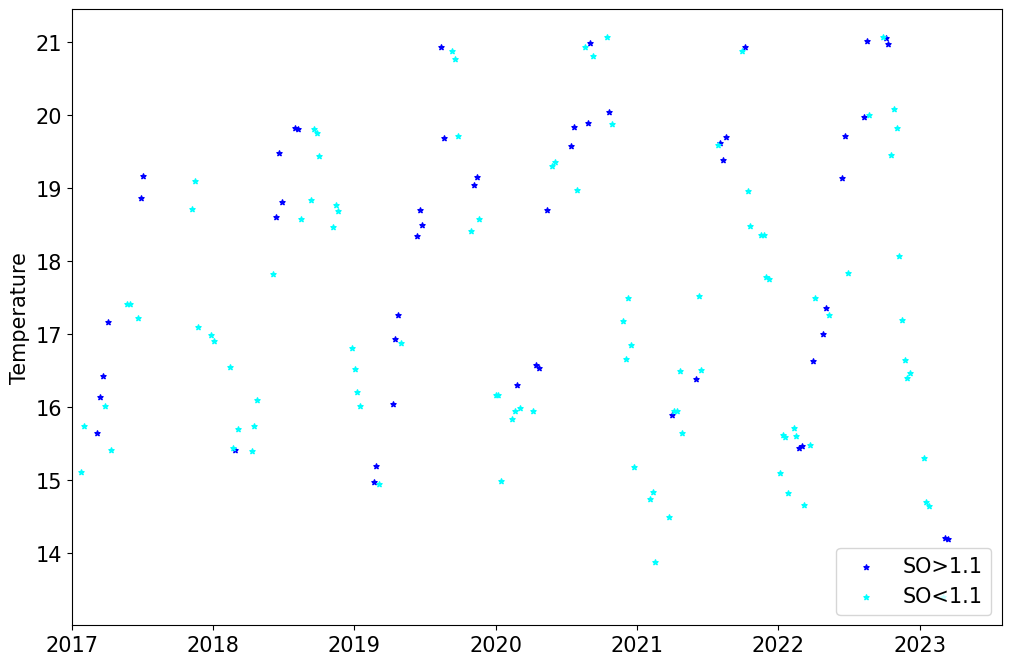

In [41]:
grid = grid_resample_max
sval = 15.0

fig = plt.figure(figsize=(12,8))
plt.clf()
ax = plt.gca()

#ax.scatter(grid.time, grid.doxy, s=sval)

# OC
# Split by gt/lt
sat_lim = 1.1
#saturated = grid_resample_max.SO > sat_lim
saturated = grid.SO > sat_lim
ax.scatter(grid.time[saturated], grid['T'][saturated], s=sval, color='blue', marker='*', label=f'SO>{sat_lim}')
ax.scatter(grid.time[~saturated], grid['T'][~saturated], s=sval, color='cyan', marker='*', label=f'SO<{sat_lim}')

ax.set_xlim(pandas.Timestamp('2017-01-01'), pandas.Timestamp('2023-08-01'))
ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=1))

ax.set_ylabel('Temperature')

plot_utils.set_fontsize(ax, 15.)
ax.legend(fontsize=15., loc='lower right')

plt.savefig('fig_interannualT.png', dpi=300)


plt.show()